In [1]:
import glob
import cv2
import imutils
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from skimage import io

from google.colab import drive
drive.mount('/content/drive')

file_list = glob.glob('/content/drive/MyDrive/MMU-Iris-Database/1/left/*.*')
print(file_list)

num_list=[]
for x in range(1,47):
  num_list.append(x)

print(num_list)

images = []
for i in num_list:
    file_list = glob.glob('/content/drive/MyDrive/MMU-Iris-Database/' + str(i) + '/left/*.*')
    for file in file_list:
      im = cv2.imread(file)
      images.append(im)
    file_list = glob.glob('/content/drive/MyDrive/MMU-Iris-Database/' + str(i) + '/right/*.*')
    for file in file_list:
      im = cv2.imread(file)
      images.append(im)

print(len(images))


Mounted at /content/drive
['/content/drive/MyDrive/MMU-Iris-Database/1/left/aeval1.bmp', '/content/drive/MyDrive/MMU-Iris-Database/1/left/aeval5.bmp', '/content/drive/MyDrive/MMU-Iris-Database/1/left/aeval3.bmp', '/content/drive/MyDrive/MMU-Iris-Database/1/left/aeval4.bmp', '/content/drive/MyDrive/MMU-Iris-Database/1/left/aeval2.bmp']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
450


In [45]:
import numpy as np
from scipy import signal
from scipy.signal import fftconvolve


def searchInnerBound(img):
  
    # Integro-Differential operator coarse (jump-level precision)
    Y = img.shape[0]
    X = img.shape[1]
    sect = X/4	
    minrad = 10
    maxrad = sect*0.8
    jump = 4 		

    # Hough Space (y,x,r)
    sz = np.array([np.floor((Y-2*sect)/jump),
                    np.floor((X-2*sect)/jump),
                    np.floor((maxrad-minrad)/jump)]).astype(int)

    # Resolution of the circular integration
    integrationprecision = 1
    angs = np.arange(0, 2*np.pi, integrationprecision)
    x, y, r = np.meshgrid(np.arange(sz[1]),
                          np.arange(sz[0]),
                          np.arange(sz[2]))
    y = sect + y*jump
    x = sect + x*jump
    r = minrad + r*jump
    hs = ContourIntegralCircular(img, y, x, r, angs)

    # Hough Space Partial Derivative R
    hspdr = hs - hs[:, :, np.insert(np.arange(hs.shape[2]-1), 0, 0)]

    # Blur
    sm = 3 		
    hspdrs = fftconvolve(hspdr, np.ones([sm,sm,sm]), mode="same")

    indmax = np.argmax(hspdrs.ravel())
    y,x,r = np.unravel_index(indmax, hspdrs.shape)

    inner_y = sect + y*jump
    inner_x = sect + x*jump
    inner_r = minrad + (r-1)*jump

    # Integro-Differential operator fine (pixel-level precision)
    integrationprecision = 0.1 		# Resolution of the circular integration
    angs = np.arange(0, 2*np.pi, integrationprecision)
    x, y, r = np.meshgrid(np.arange(jump*2),
                          np.arange(jump*2),
                          np.arange(jump*2))
    y = inner_y - jump + y
    x = inner_x - jump + x
    r = inner_r - jump + r
    hs = ContourIntegralCircular(img, y, x, r, angs)

    # Hough Space Partial Derivative R
    hspdr = hs - hs[:, :, np.insert(np.arange(hs.shape[2]-1), 0, 0)]

    # Bluring
    sm = 3 		
    hspdrs = signal.fftconvolve(hspdr, np.ones([sm,sm,sm]), mode="same")
    indmax = np.argmax(hspdrs.ravel())
    y,x,r = np.unravel_index(indmax, hspdrs.shape)

    inner_y = inner_y - jump + y
    inner_x = inner_x - jump + x
    inner_r = inner_r - jump + r - 1

    return inner_y, inner_x, inner_r

def searchOuterBound(img, inner_y, inner_x, inner_r):
   
    maxdispl = np.round(inner_r*0.15).astype(int)

    minrad = np.round(inner_r/0.8).astype(int)
    maxrad = np.round(inner_r/0.3).astype(int)

    # Integration region, avoiding eyelids
    intreg = np.array([[2/6, 4/6], [8/6, 10/6]]) * np.pi

    # Resolution of the circular integration
    integrationprecision = 0.05
    angs = np.concatenate([np.arange(intreg[0,0], intreg[0,1], integrationprecision),
                            np.arange(intreg[1,0], intreg[1,1], integrationprecision)],
                            axis=0)
    x, y, r = np.meshgrid(np.arange(2*maxdispl),
                          np.arange(2*maxdispl),
                          np.arange(maxrad-minrad))
    y = inner_y - maxdispl + y
    x = inner_x - maxdispl + x
    r = minrad + r
    hs = ContourIntegralCircular(img, y, x, r, angs)

    # Hough Space Partial Derivative R
    hspdr = hs - hs[:, :, np.insert(np.arange(hs.shape[2]-1), 0, 0)]

    # Blur
    sm = 7 	
    hspdrs = fftconvolve(hspdr, np.ones([sm,sm,sm]), mode="same")

    indmax = np.argmax(hspdrs.ravel())
    y,x,r = np.unravel_index(indmax, hspdrs.shape)

    outer_y = inner_y - maxdispl + y + 1
    outer_x = inner_x - maxdispl + x + 1
    outer_r = minrad + r - 1
    
    return outer_y, outer_x, outer_r

def ContourIntegralCircular(imagen, y_0, x_0, r, angs):

    # Get y, x
    y = np.zeros([len(angs), r.shape[0], r.shape[1], r.shape[2]], dtype=int)
    x = np.zeros([len(angs), r.shape[0], r.shape[1], r.shape[2]], dtype=int)
    for i in range(len(angs)):
        ang = angs[i]
        y[i, :, :, :] = np.round(y_0 - np.cos(ang) * r).astype(int)
        x[i, :, :, :] = np.round(x_0 + np.sin(ang) * r).astype(int)

    # Adapt y
    ind = np.where(y < 0)
    y[ind] = 0
    ind = np.where(y >= imagen.shape[0])
    y[ind] = imagen.shape[0] - 1

    # Adapt x
    ind = np.where(x < 0)
    x[ind] = 0
    ind = np.where(x >= imagen.shape[1])
    x[ind] = imagen.shape[1] - 1

    # Return
    hs = imagen[y, x]
    hs = np.sum(hs, axis=0)
    return hs.astype(float)

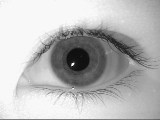

51.0 67.0 19
51.0 67.0 27


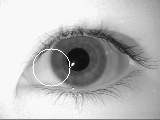

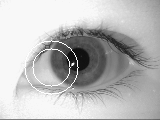

In [118]:
img = images[0]
img = cv2.resize(img ,(160,120))
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)

rowp, colp, rp = searchInnerBound(gray_image)
row, col, r = searchOuterBound(gray_image, rowp, colp, rp)

print(rowp,colp,rp)
print(row,col,r)
centre = (int(rowp),int(colp))
radius = rp
color = (255,0,0)
thickness = 1
ccimg = cv2.circle(gray_image , centre , radius ,color ,thickness)
cv2_imshow(ccimg)
centre1 = (int(row),int(col))
radius1 = r
ccimg1 = cv2.circle(ccimg , centre , radius1 ,color ,thickness)
cv2_imshow(ccimg1)

In [115]:
from skimage.util.dtype import img_as_float
def detect_pupil(img):
        # First binarize the image so that findContours can work correctly.
        _, thresh = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
        # Now find the contours and then find the pupil in the contours.
        contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        c = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 2, img.shape[0]/2)
        # Then mask the pupil from the image and store it's coordinates.
        for l in c:
            # OpenCV returns the circles as a list of lists of circles
            for circle in l:
                center = (circle[0], circle[1])
                radius = circle[2]
                cv2.circle(img, center, radius, (0, 0, 0), thickness = 1)
                pupil = (center[0], center[1], radius)
        return centre[0],centre[1],radius
        
def detect_iris(img):
        pupil = detect_pupil(img)
        _, t = cv2.threshold(img, 195, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(t, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Find the iris using the radius of the pupil as input.
        c = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 2, pupil[2] * 2, param2 = 100)

        for l in c:
            for circle in l:
                center = (pupil[0], pupil[1])
                radius = circle[2]
                # This creates a black image and draws an iris-sized white circle in it.
                mask = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)
                # cv2.circle(mask, center, radius, (255, 0, 0), thickness = 1)
                # Mask the iris and crop everything outside of its radius.
                img = cv2.bitwise_and(img, mask)
        return img

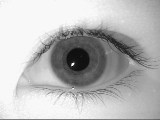

51 67 36.6


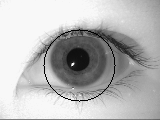

In [117]:
img = images[0]
img = cv2.resize(img ,(160,120))
gray_image1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image1)

rowp, colp, rp = detect_pupil(gray_image1)
# row, col, r = searchOuterBound(img.mean(axis=-1), rowp, colp, rp)

print(rowp,colp,rp)
# print(row,col,r)

centre = (int(rowp),int(colp))
radius = rp
color = (255,0,0)
thickness = 1
# ccimg3 = cv2.circle(gray_image1 , centre , radius ,color ,thickness)
cv2_imshow(gray_image1)